In [1]:
import re
import joblib
from joblib import dump, load

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    OrdinalEncoder, 
    LabelEncoder, 
    OneHotEncoder,
    PolynomialFeatures
)

from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)

from sklearn.ensemble import RandomForestClassifier

import sklearn.metrics as skmet

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    fbeta_score,
    roc_auc_score, 
    average_precision_score,
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay, 
    RocCurveDisplay, 
    precision_recall_curve,
)

import yellowbrick.model_selection as ms

import xgboost
from xgboost import XGBClassifier
from hyperopt.pyll.base import scope
from hyperopt import (
    fmin, 
    tpe, 
    hp, 
    STATUS_OK, 
    Trials
)

from typing import (
    Any, 
    Dict, 
    Union, 
    Sequence
)

pd.set_option('display.max_columns', None)
pd.options.plotting.backend = 'matplotlib'

In [2]:
color_palette = ["#CF2011", "#E42313", "#EB5A4E", "#F29189", "#FFFFFF", "#B8B7B7", "#706F6F", "#1D1D1B"]
fp = (matplotlib
      .font_manager
      .FontProperties(fname='/Fonts/roboto/Roboto-Condensed.ttf')
     )
sns.set_palette(color_palette)
sns.set_style("whitegrid", 
              {"grid.color": "#ffffff", 
               "axes.facecolor": "w", 
               "figure.facecolor":"white"})

In [3]:
df = (pd
      .read_csv('churn_only.csv')
     )
df

,tenure_months,tenure_segmentation,location,device_class,games_product,music_product,education_product,video_product,any_digital_product,all_digital_product,total_digital_product_used,call_center,use_myapp,total_product_utilisation,payment_method,monthly_purchase_thou_idr_,cltv_predicted_thou_idr_,total_spending,net_cltv_total_spending
0,2,low,Jakarta,Mid End,Yes,Yes,No,No,1,0,2,No,No,2,Digital Wallet,70.00,4212.0,140.0,4070.0
1,2,low,Jakarta,High End,No,No,No,No,0,0,0,No,No,0,Pulsa,91.94,3512.0,183.9,3328.0
2,8,medium,Jakarta,High End,No,No,Yes,Yes,1,0,2,No,Yes,3,Pulsa,129.50,6984.0,1036.0,5948.0
3,28,high,Jakarta,High End,No,No,Yes,Yes,1,0,2,Yes,Yes,4,Pulsa,136.20,6504.0,3814.0,2690.0
4,49,high,Jakarta,High End,No,Yes,Yes,Yes,1,0,3,No,Yes,4,Debit,134.80,6944.0,6604.0,336.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,12,high,Jakarta,Mid End,No,No,No,Yes,1,0,1,Yes,No,2,Pulsa,77.75,5956.0,933.0,5024.0
1865,9,medium,Jakarta,Mid End,No,No,No,No,0,0,0,No,No,0,Debit,57.47,2638.0,517.0,2120.0
1866,1,low,Jakarta,High End,No,No,No,No,0,0,0,No,No,0,Pulsa,98.50,7244.0,98.5,7144.0
1867,67,high,Jakarta,High End,Yes,Yes,Yes,Yes,1,1,4,No,No,4,Credit,133.90,7304.0,8970.0,-1661.0


In [4]:
def get_var(df, var_name):
    globals()[var_name] = df
    return df

In [5]:
class TweakCustomerChurn(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        digital_product_cols = ['games_product', 'music_product', 'education_product', 'video_product']
        all_product_cols = ['games_product', 'music_product', 'education_product', 'video_product', 'call_center', 'use_myapp']
        
        return (X
                .rename(columns=lambda col: re.compile(r'[^a-zA-Z0-9_]+').sub('_', col.lower()))
                .assign(tenure_segmentation=lambda df_: np.where(df_.tenure_months < 4, "low", np.where(df_.tenure_months < 12, "medium", "high")),
                        any_digital_product=lambda df_: np.where((df_.games_product == "Yes") | (df_.music_product == "Yes") | (df_.education_product == "Yes") | (df_.video_product == "Yes"), 1, 0),
                        all_digital_product=lambda df_: np.where((df_.games_product == "Yes") & (df_.music_product == "Yes") & (df_.education_product == "Yes") & (df_.video_product == "Yes"), 1, 0),
                        total_digital_product_used=lambda df_: df_[digital_product_cols].apply(lambda row: sum(row == 'Yes'), axis=1),
                        total_product_utilisation=lambda df_: df_[all_product_cols].apply(lambda row: sum(row == 'Yes'), axis=1),
                        total_spending=lambda df_: df_.tenure_months.mul(df_.monthly_purchase_thou_idr_),
                        net_cltv_total_spending=lambda df_: df_.cltv_predicted_thou_idr_.sub(df_.total_spending)
                        ) 
                .astype({**{k: "int8"
                            for k in ["tenure_months", "any_digital_product", "all_digital_product", "total_digital_product_used", "total_product_utilisation"]},
                         **{k: "float16"
                            for k in ["monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending", "net_cltv_total_spending"]},
                         **{k: "category"
                            for k in ["tenure_segmentation", "location", "device_class", "games_product", "music_product", "education_product", "call_center", "video_product", "use_myapp", "payment_method"]}})
                .reindex(columns=["tenure_months", "tenure_segmentation", "location", "device_class", "games_product", "music_product", "education_product", "video_product", "any_digital_product", "all_digital_product", "total_digital_product_used", "call_center", "use_myapp", "total_product_utilisation", "payment_method", "monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending", "net_cltv_total_spending"])
               )

In [6]:
(TweakCustomerChurn()
 .transform(df)
)

,tenure_months,tenure_segmentation,location,device_class,games_product,music_product,education_product,video_product,any_digital_product,all_digital_product,total_digital_product_used,call_center,use_myapp,total_product_utilisation,payment_method,monthly_purchase_thou_idr_,cltv_predicted_thou_idr_,total_spending,net_cltv_total_spending
0,2,low,Jakarta,Mid End,Yes,Yes,No,No,1,0,2,No,No,2,Digital Wallet,70.00000,4212.0,140.000,4072.00
1,2,low,Jakarta,High End,No,No,No,No,0,0,0,No,No,0,Pulsa,91.93750,3512.0,183.875,3328.00
2,8,medium,Jakarta,High End,No,No,Yes,Yes,1,0,2,No,Yes,3,Pulsa,129.50000,6984.0,1036.000,5948.00
3,28,high,Jakarta,High End,No,No,Yes,Yes,1,0,2,Yes,Yes,4,Pulsa,136.25000,6504.0,3814.000,2690.00
4,49,high,Jakarta,High End,No,Yes,Yes,Yes,1,0,3,No,Yes,4,Debit,134.75000,6944.0,6604.000,338.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,12,high,Jakarta,Mid End,No,No,No,Yes,1,0,1,Yes,No,2,Pulsa,77.75000,5956.0,933.000,5024.00
1865,9,medium,Jakarta,Mid End,No,No,No,No,0,0,0,No,No,0,Debit,57.46875,2638.0,517.000,2120.00
1866,1,low,Jakarta,High End,No,No,No,No,0,0,0,No,No,0,Pulsa,98.50000,7244.0,98.500,7144.00
1867,67,high,Jakarta,High End,Yes,Yes,Yes,Yes,1,1,4,No,No,4,Credit,133.87500,7304.0,8968.000,-1667.00


In [7]:
(TweakCustomerChurn()
 .transform(df)
 .loc[lambda df_: df_['net_cltv_total_spending'].gt(0)]
)

,tenure_months,tenure_segmentation,location,device_class,games_product,music_product,education_product,video_product,any_digital_product,all_digital_product,total_digital_product_used,call_center,use_myapp,total_product_utilisation,payment_method,monthly_purchase_thou_idr_,cltv_predicted_thou_idr_,total_spending,net_cltv_total_spending
0,2,low,Jakarta,Mid End,Yes,Yes,No,No,1,0,2,No,No,2,Digital Wallet,70.00000,4212.0,140.000,4072.00
1,2,low,Jakarta,High End,No,No,No,No,0,0,0,No,No,0,Pulsa,91.93750,3512.0,183.875,3328.00
2,8,medium,Jakarta,High End,No,No,Yes,Yes,1,0,2,No,Yes,3,Pulsa,129.50000,6984.0,1036.000,5948.00
3,28,high,Jakarta,High End,No,No,Yes,Yes,1,0,2,Yes,Yes,4,Pulsa,136.25000,6504.0,3814.000,2690.00
4,49,high,Jakarta,High End,No,Yes,Yes,Yes,1,0,3,No,Yes,4,Debit,134.75000,6944.0,6604.000,338.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863,1,low,Jakarta,High End,No,No,No,No,0,0,0,No,No,0,Digital Wallet,91.87500,4500.0,91.875,4408.00
1864,12,high,Jakarta,Mid End,No,No,No,Yes,1,0,1,Yes,No,2,Pulsa,77.75000,5956.0,933.000,5024.00
1865,9,medium,Jakarta,Mid End,No,No,No,No,0,0,0,No,No,0,Debit,57.46875,2638.0,517.000,2120.00
1866,1,low,Jakarta,High End,No,No,No,No,0,0,0,No,No,0,Pulsa,98.50000,7244.0,98.500,7144.00


In [8]:
ohe_categorical_features = ['tenure_segmentation', 'location', 'device_class', 'games_product', 'music_product', 'education_product', 'video_product', 'call_center', 'use_myapp', 'payment_method']
ohe_categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

# orde_categorical_features = ['tenure_segmentation']
# orde_categorical_transformer = Pipeline(steps=[
#     ('orde', OrdinalEncoder(dtype='float'))
# ])

col_trans_xgb = ColumnTransformer(
    transformers=[
        ('ohe_categorical_features', ohe_categorical_transformer, ohe_categorical_features),
        # ('orde_categorical_features', orde_categorical_transformer, orde_categorical_features),
    ], 
    remainder='passthrough', 
    verbose=0, 
    verbose_feature_names_out=False,)

In [9]:
transformed_churned_xgb = pd.DataFrame(col_trans_xgb.fit_transform(TweakCustomerChurn().transform(df).loc[lambda df_: df_['net_cltv_total_spending'].gt(0)].iloc[:, 1:]), 
                                       columns=col_trans_xgb.get_feature_names_out(input_features=TweakCustomerChurn().transform(df).loc[lambda df_: df_['net_cltv_total_spending'].gt(0)].iloc[:, 1:].columns.tolist()))

In [10]:
transformed_churned_drop = transformed_churned_xgb.drop(columns=["monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending"])

In [11]:
transformed_churned_drop

,tenure_segmentation_low,tenure_segmentation_medium,location_Jakarta,device_class_Low End,device_class_Mid End,games_product_No internet service,games_product_Yes,music_product_No internet service,music_product_Yes,education_product_No internet service,education_product_Yes,video_product_No internet service,video_product_Yes,call_center_Yes,use_myapp_No internet service,use_myapp_Yes,payment_method_Debit,payment_method_Digital Wallet,payment_method_Pulsa,any_digital_product,all_digital_product,total_digital_product_used,total_product_utilisation,net_cltv_total_spending
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,4072.00
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3328.00
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,5948.00
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,4.0,2690.00
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0,4.0,338.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4408.00
1642,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,5024.00
1643,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2120.00
1644,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7144.00


In [12]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [13]:
# Assuming df is your DataFrame and the last column is the target variable
X_xgb, y_xgb = transformed_churned_drop.iloc[:, :-1], transformed_churned_drop.iloc[:, -1]

# Split the dataset into train and test sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

In [14]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror',
                          seed=42,
                          n_jobs=-1)

In [15]:
# Fit the regressor to the training set
xg_reg.fit(X_train_xgb, y_train_xgb)

# Predict the labels of the test set
y_pred_xgb = xg_reg.predict(X_test_xgb)

# Compute and print the mean squared error of the predictions
mse_xgb = mean_squared_error(y_test_xgb, y_pred_xgb)
print(f"Mean Squared Error: {mse_xgb}")

Mean Squared Error: 3173979.286312143


In [16]:
mean_squared_error(y_test_xgb, y_pred_xgb, squared=False)

1781.5665259293976

In [17]:
@scope.define
def to_int(x):
    return int(x)

In [18]:
options = {'n_estimators': hp.choice('n_estimators', [250, 500, 1000]),
           'max_depth': scope.to_int(hp.quniform('max_depth', 3, 12, 1)),
           'min_child_weight': hp.loguniform('min_child_weight', -1, 1),
           'subsample': hp.uniform('subsample', 0.5, 1),
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': hp.uniform('reg_alpha', 0, 100),
           'reg_lambda': hp.uniform('reg_lambda', 1, 100),
           'gamma': hp.loguniform('gamma', -10, 10),
           'learning_rate': hp.loguniform('learning_rate', -7, 0),
           'random_state': 42
          }

In [19]:
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_child_weight': int(params['min_child_weight']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'gamma': params['gamma'],
        'learning_rate': params['learning_rate'],
        'objective': 'reg:squarederror'
    }
    
    # Instantiate the XGBoost regressor
    xgb_reg = xgb.XGBRegressor(**params)
    
    # Perform cross-validation
    score = -cross_val_score(xgb_reg, X_train_xgb, y_train_xgb, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    
    # Dictionary with information for Hyperopt
    return {'loss': score, 'status': STATUS_OK}

In [20]:
trials = Trials()
SEED=101

xgb_best_params = fmin(fn=objective,
                       space=options,
                       algo=tpe.suggest,
                       max_evals=500,
                       trials=trials,
                       rstate=np.random.default_rng(SEED))

100%|█████████| 500/500 [03:09<00:00,  2.63trial/s, best loss: 2422603.66723216]


In [21]:
xgb_best_params

{'colsample_bytree': 0.6711955039700991,
 'gamma': 0.00010011277425534996,
 'learning_rate': 0.010155838733448011,
 'max_depth': 3.0,
 'min_child_weight': 0.7239359544760477,
 'n_estimators': 1,
 'reg_alpha': 40.02422070692688,
 'reg_lambda': 7.900062488751933,
 'subsample': 0.994305723487274}

In [22]:
xgb_best_params = {
    'n_estimators': [250, 500, 1000][xgb_best_params['n_estimators']],
    'colsample_bytree': xgb_best_params['colsample_bytree'],
    'gamma': xgb_best_params['gamma'],
    'learning_rate': xgb_best_params['learning_rate'],
    'max_depth': int(xgb_best_params['max_depth']),
    'min_child_weight': xgb_best_params['min_child_weight'],
    'reg_alpha': xgb_best_params['reg_alpha'],
    'reg_lambda': xgb_best_params['reg_lambda'],
    'subsample': xgb_best_params['subsample']
}

In [23]:
xgb_best_params

{'n_estimators': 500,
 'colsample_bytree': 0.6711955039700991,
 'gamma': 0.00010011277425534996,
 'learning_rate': 0.010155838733448011,
 'max_depth': 3,
 'min_child_weight': 0.7239359544760477,
 'reg_alpha': 40.02422070692688,
 'reg_lambda': 7.900062488751933,
 'subsample': 0.994305723487274}

In [24]:
xgb_clf_tuned = xgb.XGBRegressor(**xgb_best_params, 
                                objective='reg:squarederror', 
                                seed=42)

xgb_clf_tuned.fit(X_train_xgb, y_train_xgb)
y_pred = xgb_clf_tuned.predict(X_test_xgb)

In [25]:
mean_squared_error(y_test_xgb, y_pred, squared=False)

1533.0728720560887

In [26]:
result = pd.DataFrame([y_test_xgb.reset_index(drop=True), y_pred]).T.rename(columns={'net_cltv_total_spending': 'y_test', 'Unnamed 0': 'y_pred'})

In [27]:
result

,y_test,y_pred
0,201.125,2795.096436
1,466.500,2368.389160
2,2500.000,4000.949463
3,4248.000,4407.925781
4,3008.000,3706.699463
...,...,...
325,7300.000,5058.384277
326,709.000,1736.400024
327,4632.000,2800.377441
328,1277.000,2178.181152


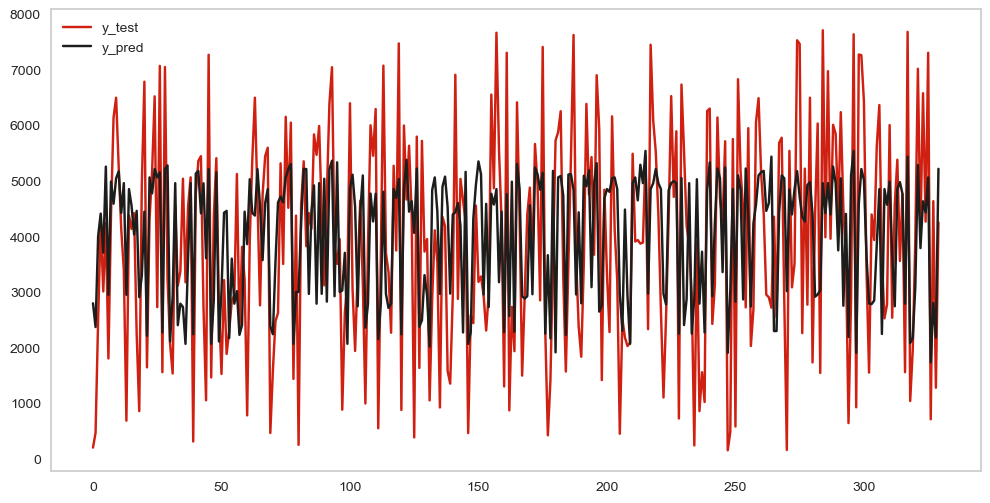

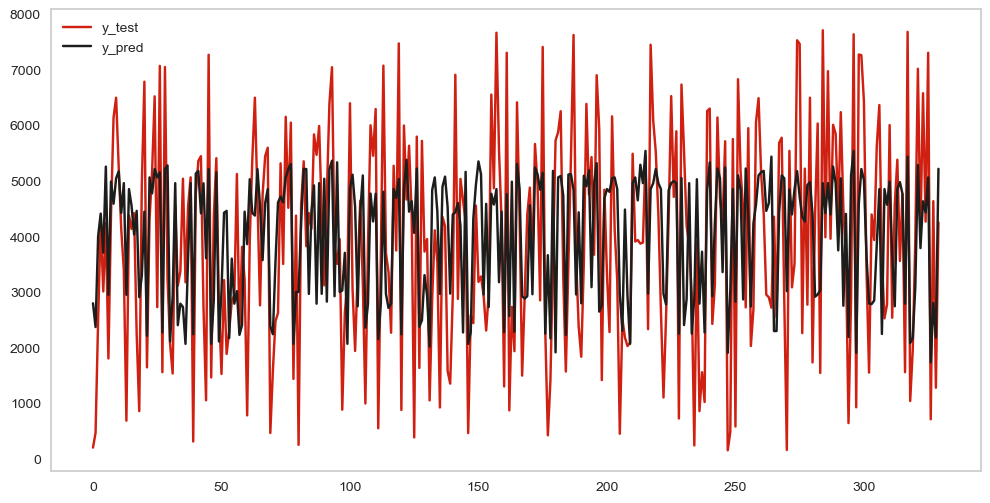

In [28]:
fig, ax = plt.subplots(figsize=(12,6))
(result
 .reset_index(drop=True)
 .plot
 .line(ax=ax, color=[color_palette[0], color_palette[7]])
)
fig

In [29]:
import seaborn.objects as so

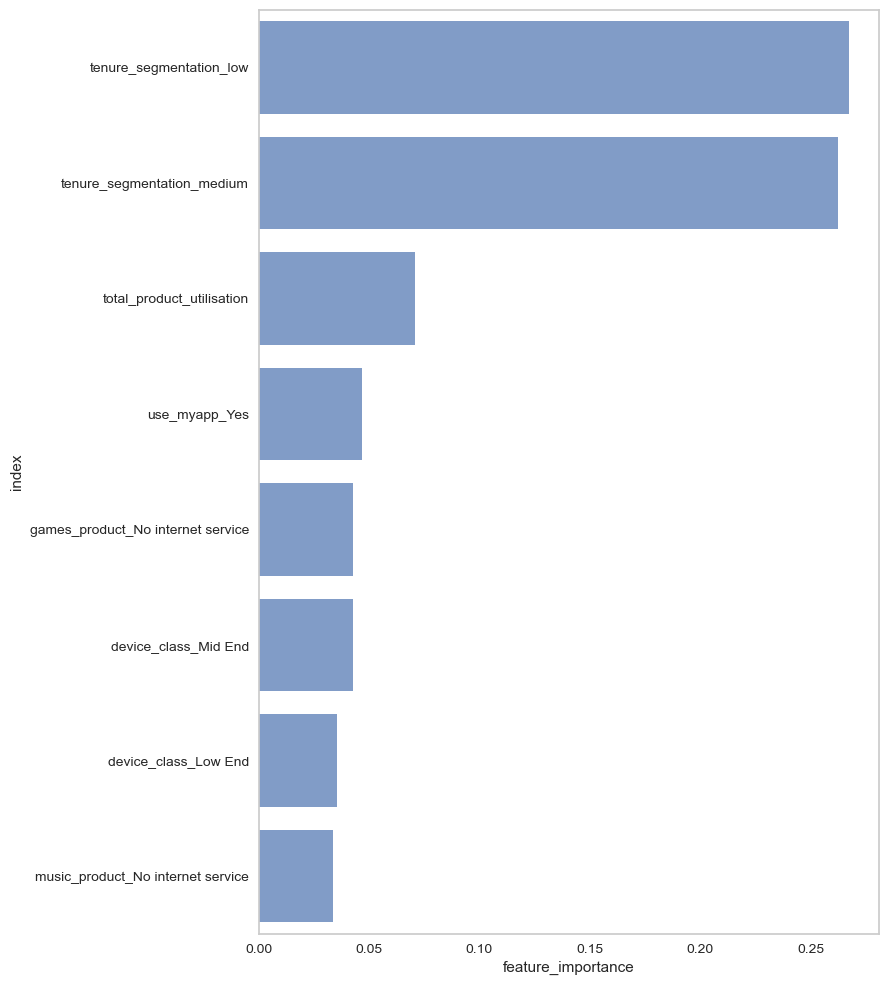

In [30]:
fig.clf()
fig, ax = plt.subplots(figsize=(8, 12))
(so
 .Plot((pd
      .DataFrame(xgb_clf_tuned.feature_importances_, index=X_xgb.columns.tolist())
      .rename(columns={0: "feature_importance"})
      .sort_values(by="feature_importance", ascending=False)
      .iloc[:8, :]
      .reset_index()),
     x='feature_importance',
     y='index'
    )
 .add(so.Bar(edgewidth=0))
 # .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[2]])})
 .on(ax)
 .show())

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


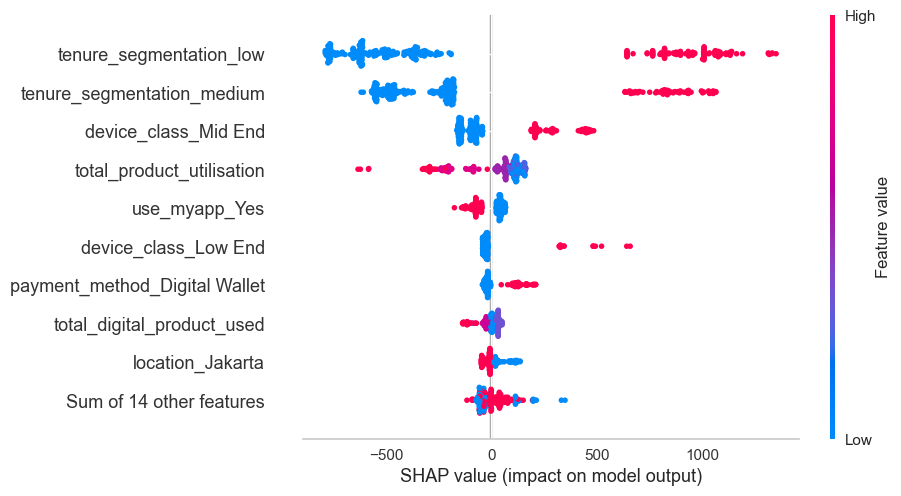

In [32]:
import shap
shap_ex = shap.TreeExplainer(xgb_clf_tuned)
vals = shap_ex(pd.DataFrame(X_test_xgb, columns=X_xgb.columns.tolist()))

shap_df = pd.DataFrame(vals.values, columns=X_xgb.columns.tolist())
shap_df

fig = plt.figure(figsize=(8, 4))
fig = shap.plots.beeswarm(vals)
fig;

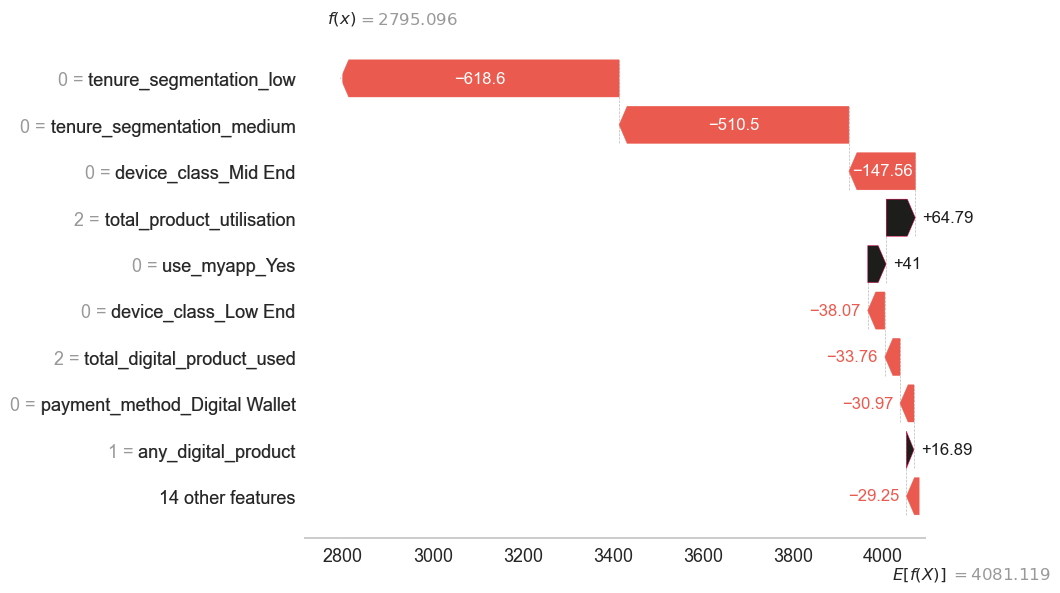

In [35]:
import shap
default_pos_color = "#ff0051"
default_neg_color = "#008bfb"

# Custom colors
positive_color = color_palette[7]
negative_color = color_palette[2]

fig = plt.figure(figsize=(8,4))
fig = shap.plots.waterfall(vals[0], show=False)
        
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if (isinstance(fcc, matplotlib.patches.FancyArrow)):
            if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
                fcc.set_facecolor(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
                fcc.set_color(negative_color)
        elif (isinstance(fcc, plt.Text)):
            if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
                fcc.set_color(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
                fcc.set_color(negative_color)

fig